In [298]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [299]:
# Cargar dataset evitando columnas irrelevantes ("Unnamed: 0" es índice y "Complaint ID" es un ID único que no aporta para análisis)
df = pd.read_csv('./data/quejas-clientes.csv', usecols=lambda column: column not in ['Unnamed: 0', 'Complaint ID'])

# Mostrar resumen de información (tipos, valores nulos) y estadística descriptiva para entender la estructura y calidad de los datos
print(df.info())
print(df.describe())

# Eliminar registros duplicados para evitar sesgar análisis y modelos futuros
num_filas_antes = df.shape[0]
df = df.drop_duplicates()
num_filas_despues = df.shape[0]
num_duplicados_eliminados = num_filas_antes - num_filas_despues
print(f'Se han eliminado {num_duplicados_eliminados} filas duplicadas.')

# Ajustar tipos manualmente a categoría para variables cualitativas (ahorra memoria y mejora rendimiento) y Int64 para ZIP code que puede contener NaN
df = df.astype({
    'Product': 'category',
    'Sub-product': 'category',
    'Issue': 'category',
    'Sub-issue': 'category',
    'State': 'category',
    'ZIP code': 'Int64',  # Permite números enteros con NaN (pandas extension type)
    'Company': 'category',
    'Company response': 'category',
    'Timely response?': 'category',
    'Consumer disputed?': 'category'
})

# Convertir columnas de fecha a datetime, usando 'coerce' para convertir errores a NaT y permitir detección posterior
df['Date received'] = pd.to_datetime(df['Date received'], format='%Y-%m-%d', errors='coerce')
df['Date sent to company'] = pd.to_datetime(df['Date sent to company'], format='%Y-%m-%d', errors='coerce')

# Verificar cuántos errores (NaT) hay después de la conversión para evaluar calidad temporal
num_errores = df['Date received'].isna().sum()
print(f'Número de valores con error en "Date received": {num_errores}')

num_errores2 = df['Date sent to company'].isna().sum()
print(f'Número de valores con error en "Date sent to company": {num_errores2}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product               28156 non-null  object 
 1   Sub-product           17582 non-null  object 
 2   Issue                 28154 non-null  object 
 3   Sub-issue             13211 non-null  object 
 4   State                 27735 non-null  object 
 5   ZIP code              27876 non-null  float64
 6   Date received         28156 non-null  object 
 7   Date sent to company  28156 non-null  object 
 8   Company               28156 non-null  object 
 9   Company response      28156 non-null  object 
 10  Timely response?      28156 non-null  object 
 11  Consumer disputed?    6006 non-null   object 
dtypes: float64(1), object(11)
memory usage: 2.6+ MB
None
           ZIP code
count  27876.000000
mean   49921.466423
std    30633.853920
min        9.000000
25%    23228.000000

He puesto todas las clases a categoricas (quitando las fechas y el ZIP). String no tenia mucho sentido mantenerlo por si luego ago un clasificador, y así poder codificarlas en un futuro si es necesario. 

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




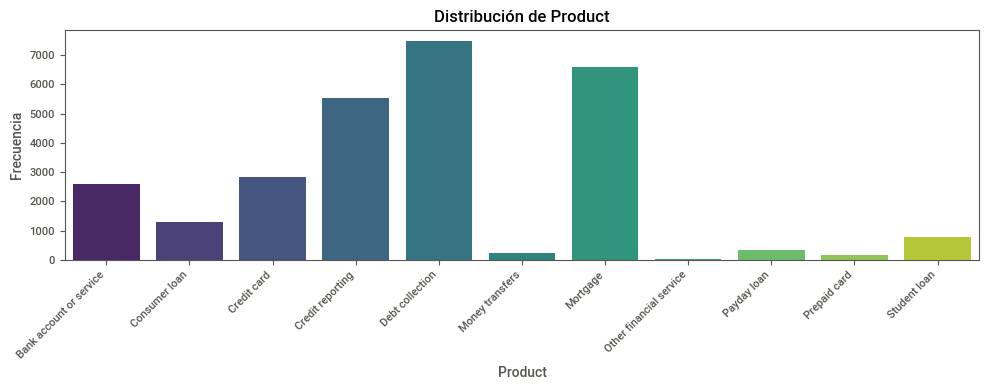

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




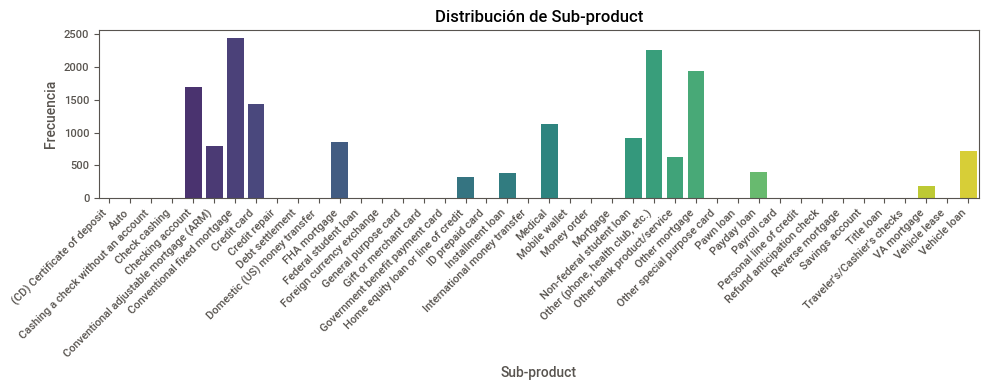

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




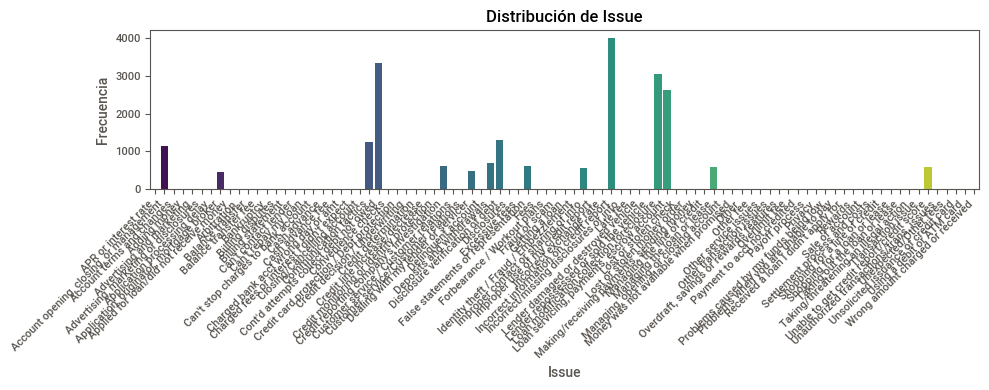

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




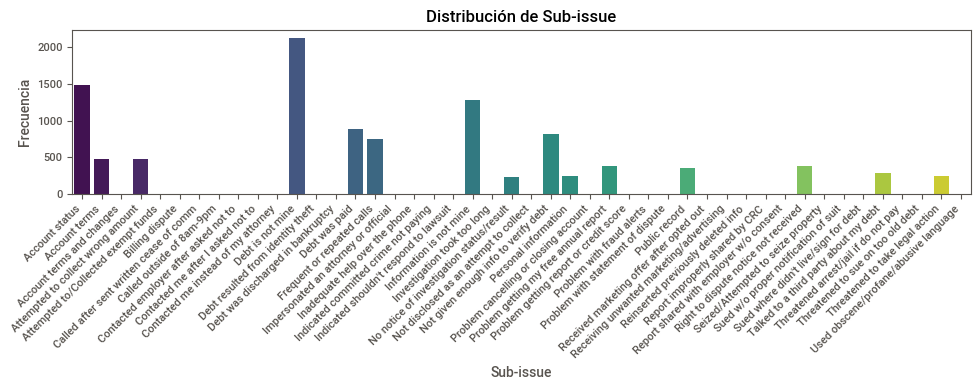

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




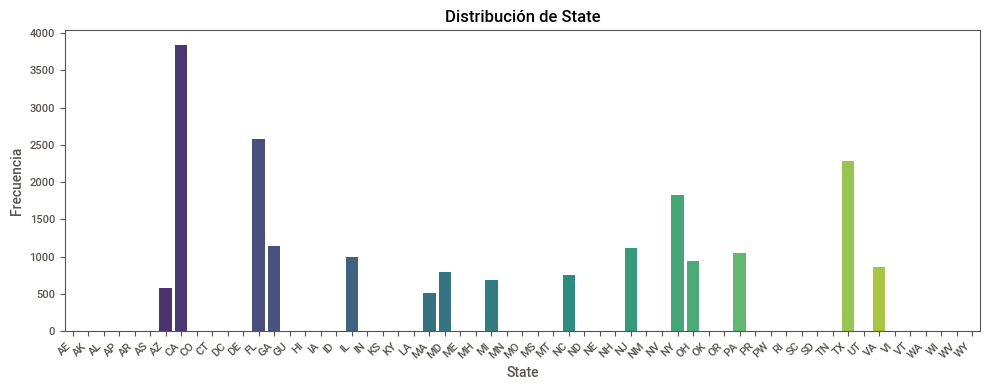

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:15: UserWarning:

Glyph 133 (\x85) missing from font(s) Roboto.

c:\Users\ingenia\Desktop\The Bridge\DSPT2025-ML\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 133 (\x85) missing from font(s) Roboto.



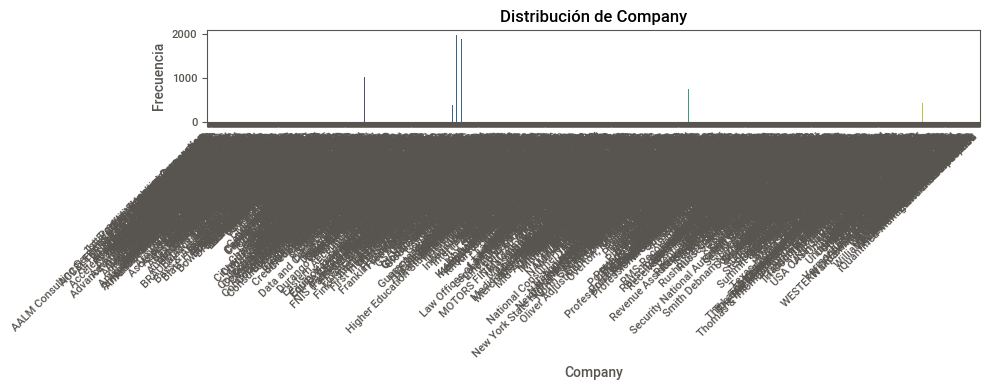

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




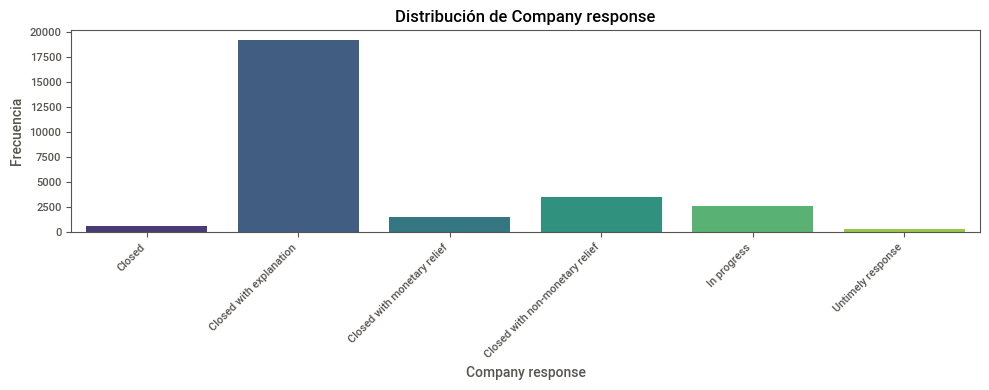

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




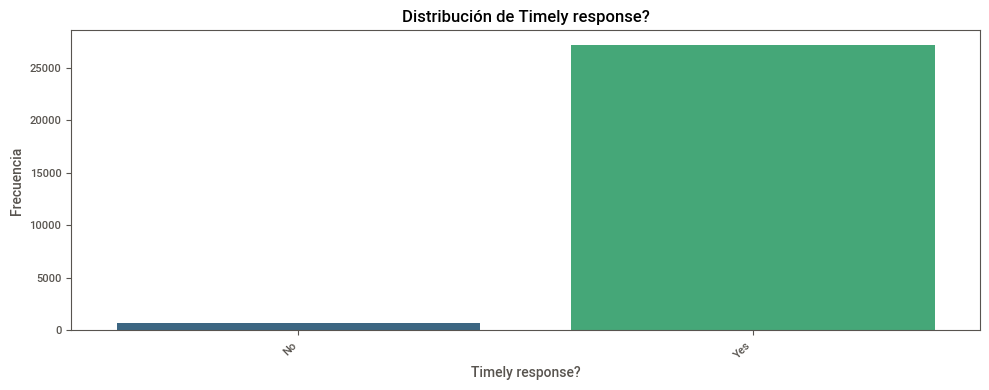

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




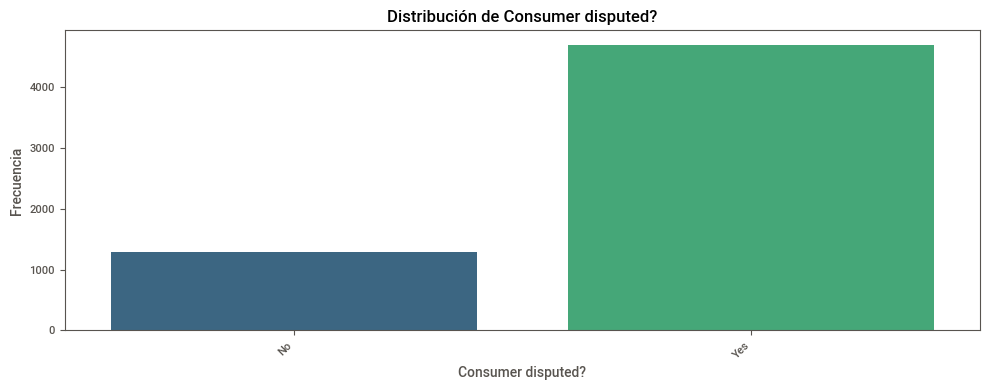

In [300]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selección de columnas categóricas excluyendo ZIP code por alta cardinalidad
cat_cols = [col for col in df.select_dtypes(include=['category']).columns if col != 'ZIP code']

# Para cada variable categórica, graficamos las 15 categorías más frecuentes (evita saturar el gráfico)
for col in cat_cols:
    plt.figure(figsize=(10, 4))
    top_values = df[col].value_counts().nlargest(15)
    sns.barplot(x=top_values.index, y=top_values.values, palette="viridis")
    plt.title(f'Distribución de {col}')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


He hecho un pequeño analisis de las variables categoricas, estos son los resultados:

- Product -> 11 valores distintos, 0 nulos
- Sub-product -> 41 valores distintos, 10373 (37.15% del total) nulos si ago la suma no me da 28156 #TO-DO!!!!!!!!!!!!!!
- Issue -> 89 valores distintos, 2 nulos < 0.001% del total
- Sub-issue -> 46 valores distintos, 14914 (53.42% del total) nulos
- State -> 59 valores distintos, 419 (1.50% del total) nulos
- Company -> 1534 valores distintos, 0 nulos
- Company response -> 6 valores distintos, 0 nulos
- Timely response? -> 2 valores distintos, 0 nulos
- Consumer disputed? -> 2 valores distintos, 21936 (78.57% del total) nulos

Esta información esta muy bien para tener una visión general de cada variable.
Podemos ver que hay ciertas variables que son imprescindibles en el dataset, es decir que son muy importantes para el control de quejas, como por ejemplo el producto, la compañia, los tiempos de respuesta o el problema en si. Tambien podemos considerar que el estado es parte de este grupo por su poca cantidad de valores faltantes. 

Por otro lado tenemos variables adicionales que nos proporcionan un poco más de información sobre el caso, como podrían ser el sub producto, sub-issue y si el cliente ha disputado, que esta información no siempre esta accesible ya que el dataset tiene una gran cantidad de valores faltantes para estas variables 

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




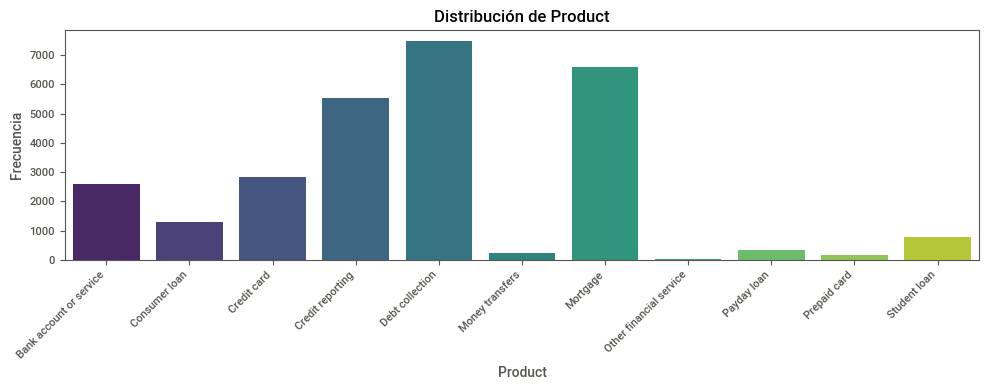

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




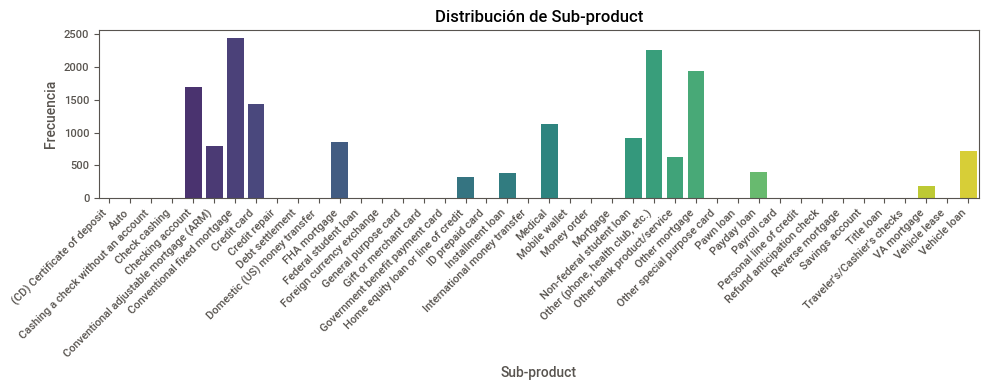

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




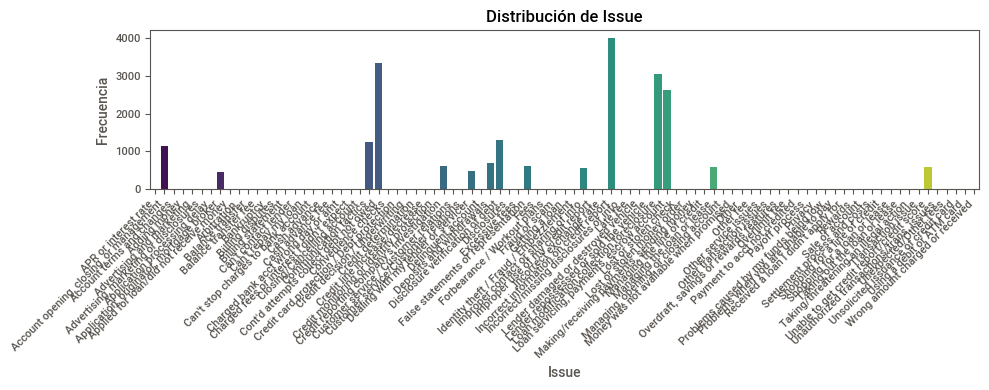

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




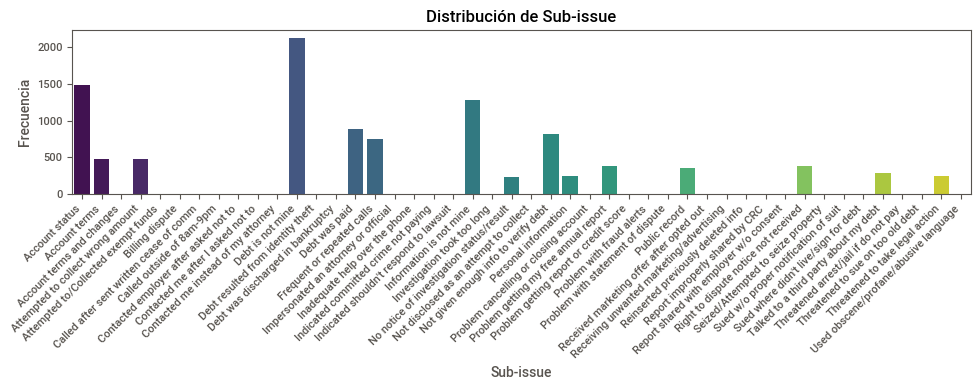

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




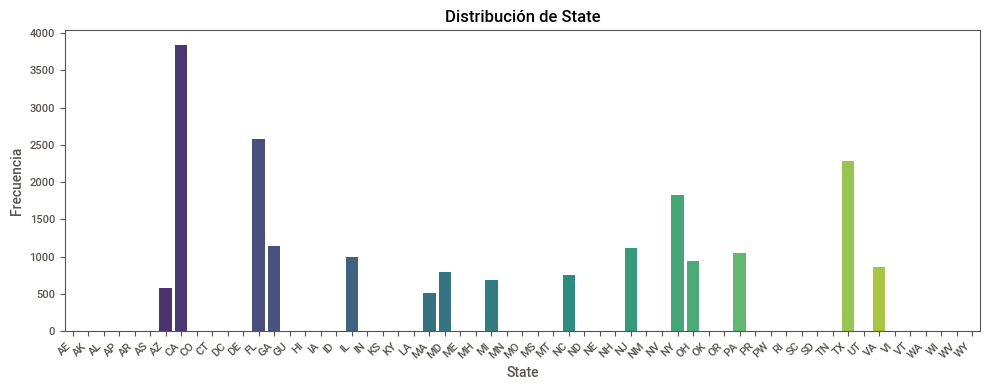

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:15: UserWarning:

Glyph 133 (\x85) missing from font(s) Roboto.

c:\Users\ingenia\Desktop\The Bridge\DSPT2025-ML\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 133 (\x85) missing from font(s) Roboto.



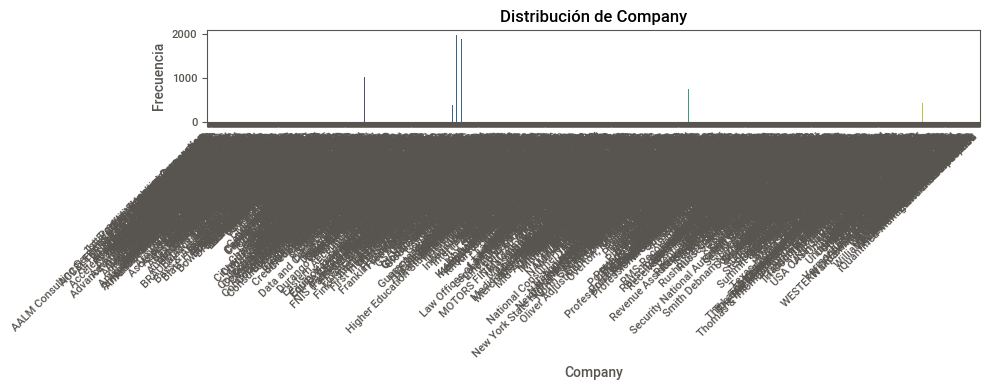

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




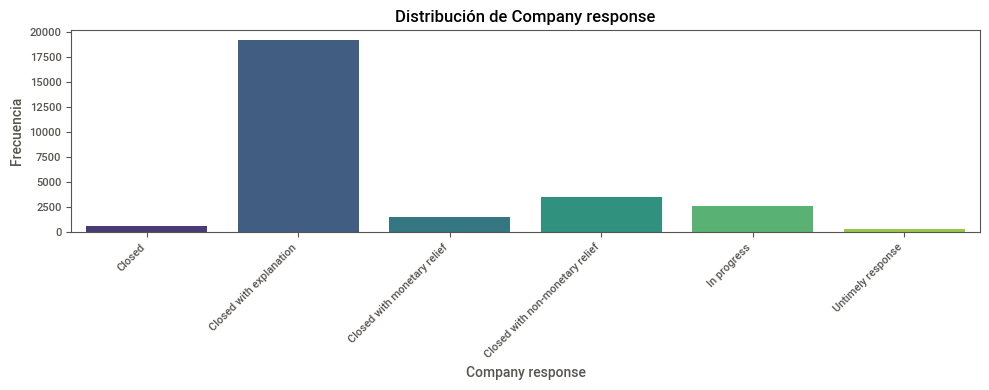

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




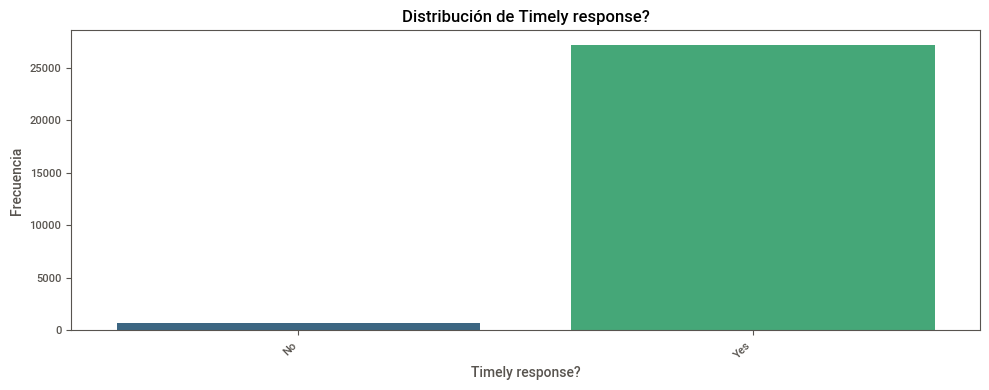

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\3996317058.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




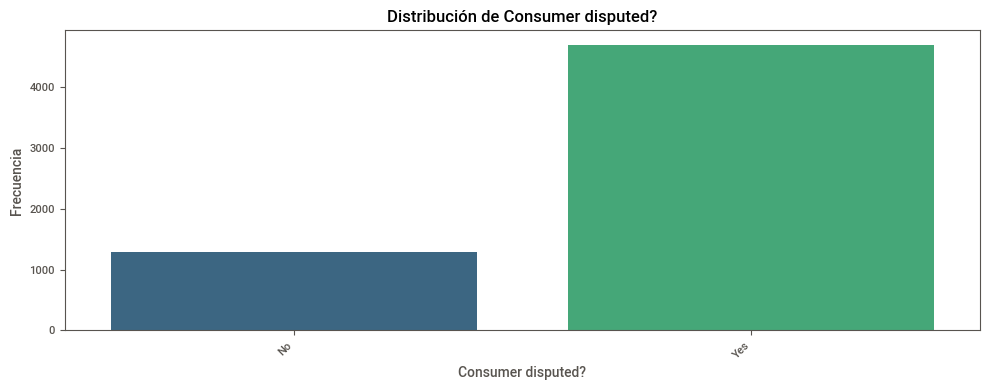

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selección de columnas categóricas excluyendo ZIP code por alta cardinalidad
cat_cols = [col for col in df.select_dtypes(include=['category']).columns if col != 'ZIP code']

# Para cada variable categórica, graficamos las 15 categorías más frecuentes (evita saturar el gráfico)
for col in cat_cols:
    plt.figure(figsize=(10, 4))
    top_values = df[col].value_counts().nlargest(15)
    sns.barplot(x=top_values.index, y=top_values.values, palette="viridis")
    plt.title(f'Distribución de {col}')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Visualizando un poco la distribución de cada variable, vemos que no tenemos los resultados que nos gustaría. Vemos por lo general en todas las variables hay predominancia de ciertas categorias. 

En el caso de los productos es la variable con mejor distribución. Pero en el caso de los sub-productos ya vemos que de los 41 tipos diferentes que hay solo 15 tienen una cantidad visible de muestras.

En el caso de las issues tenemos una peor casuistica solo 15 de 89 tipos diferentes tienen muestras visibles en la distribución. En las sub issues aumenta a 15/46 pero sin tener en cuenta la grán cantidad de valores nulos que tenemos.
 
En cuanto a los estados tenemos una predominancia de ciertos estados muy notoria 15/59 estados estan representados en la distribución adecuadamente. 

El caso de las compañias es el más estremo, tras tener una cantidad inmensa de empresas distintas observamos que la grán mayoria de las quejas pertenecen a un conjunto muy pequeño de ellas. 

En cuanto a las respeustas de la compañia a pesar de ser una clase con pocas categorias (6) vemos que una clase tiene una predominancia absoluta. 

Por ultimo vemos que timply response solo tiene 2 clases positivo o negativo pero la predominancia positiva hace casi obsoleta a esta variable, habría que analizar la clase de nulos haber si sigue alguna tendencia. 

Para finalizar con la ultima variable, muy parecida a la anterios pero en este caso hay que añadir que ila grán cantidad de valores nulos hace compleja la variable.


Resumiendo el dataset, es algo complejo de analizar puesto que todas las variables tienen una predominancia de ciertas categorias, hay una gran cantidad de elementos nulos lo cual complica su analisis. 



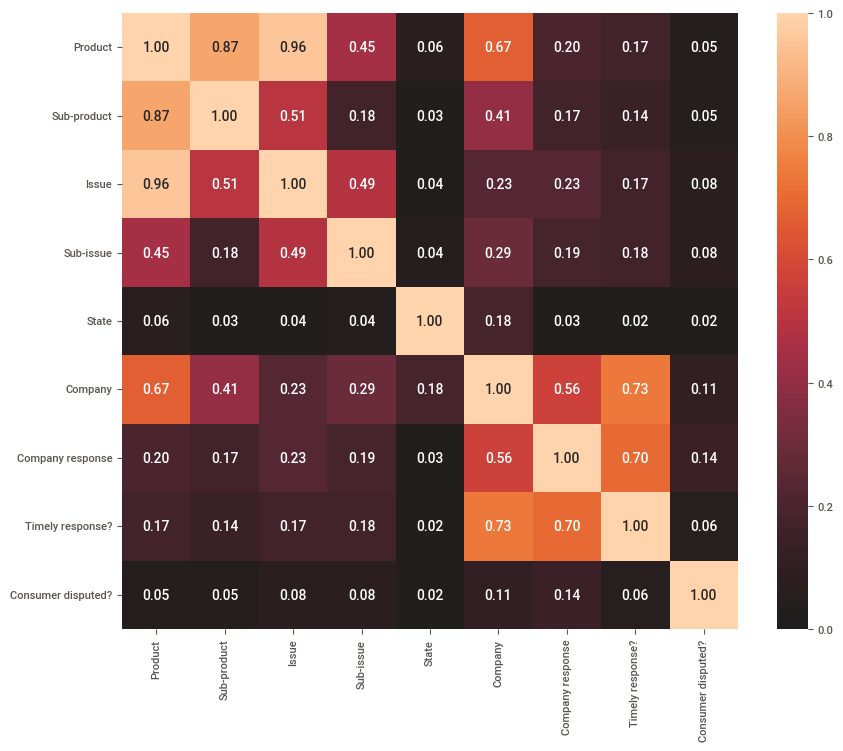

{'corr':                      Product  Sub-product     Issue  Sub-issue     State  \
 Product             1.000000     0.865178  0.960125   0.445447  0.064427   
 Sub-product         0.865178     1.000000  0.505941   0.178392  0.034232   
 Issue               0.960125     0.505941  1.000000   0.486140  0.038045   
 Sub-issue           0.445447     0.178392  0.486140   1.000000  0.043818   
 State               0.064427     0.034232  0.038045   0.043818  1.000000   
 Company             0.668613     0.406180  0.228120   0.293439  0.183665   
 Company response    0.200502     0.171190  0.231349   0.186822  0.025923   
 Timely response?    0.166847     0.139338  0.171403   0.176909  0.017534   
 Consumer disputed?  0.045073     0.046467  0.078041   0.077704  0.021584   
 
                      Company  Company response  Timely response?  \
 Product             0.668613          0.200502          0.166847   
 Sub-product         0.406180          0.171190          0.139338   
 Issue       

In [302]:
# Librería dython es útil para análisis y visualización de asociaciones entre variables categóricas robustamente
from dython.nominal import associations

# Seleccionar solo columnas categóricas, excluyendo ZIP code para claridad
cat_cols = [col for col in df.select_dtypes(include=['category']).columns if col != 'ZIP code']
categorical_df = df[cat_cols]

# Calcular y mostrar mapa de calor que muestra la fuerza de asociación entre variables categóricas (Cramér's V y otras medidas)
associations(categorical_df, plot=True, figsize=(10,8))


En cuanto a la correlación entre variables vemos que obviamente estan altamente correlacionados. Adicionalmente el producto esta más correlacionado incluso con la issue que con el sub-producto. 

Por otro lado tenemos que timely response esta correlacionado tanto con la compañia como con la respuesta de la compañia. 

El resto de correlaciones son practicamente nulas. 

In [303]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df, explorative=True)
# profile.to_notebook_iframe()  # Para verlo dentro del notebook
# # profile.to_file("reporte_completo.html")  # Para guardarlo a disco


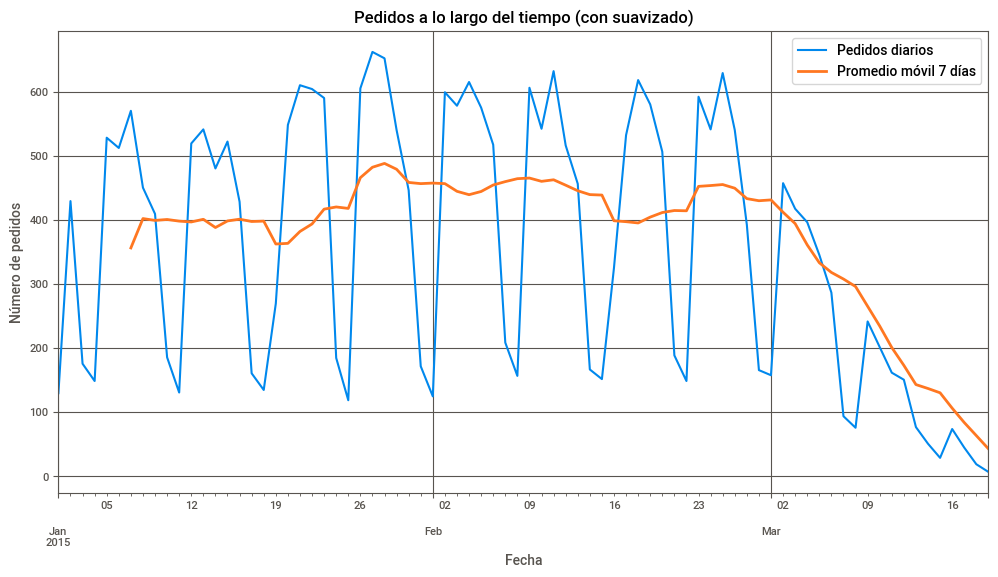

In [304]:
import matplotlib.pyplot as plt

# Asegúrate que la columna de fecha esté en formato datetime
df['Date received'] = pd.to_datetime(df['Date received'], errors='coerce')

# Contar pedidos por día
pedidos_por_dia = df.groupby('Date received').size()

pedidos_suavizados = pedidos_por_dia.rolling(window=7).mean()

plt.figure(figsize=(12, 6))
pedidos_por_dia.plot(label='Pedidos diarios')
pedidos_suavizados.plot(label='Promedio móvil 7 días', linewidth=2)
plt.legend()
plt.title('Pedidos a lo largo del tiempo (con suavizado)')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.show()



En cuanto a la estacionalidad de las quejas en base a los productos esas bajadas son correspondientes a los fines de semana, entendiendo que la actividad de las compañias baja drasticamente los fines de semana. Por lo contrario, las suvidas corresponden a los primeros dias de cada semana (lunes/martes). 

C:\Users\ingenia\AppData\Local\Temp\ipykernel_16436\173425480.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



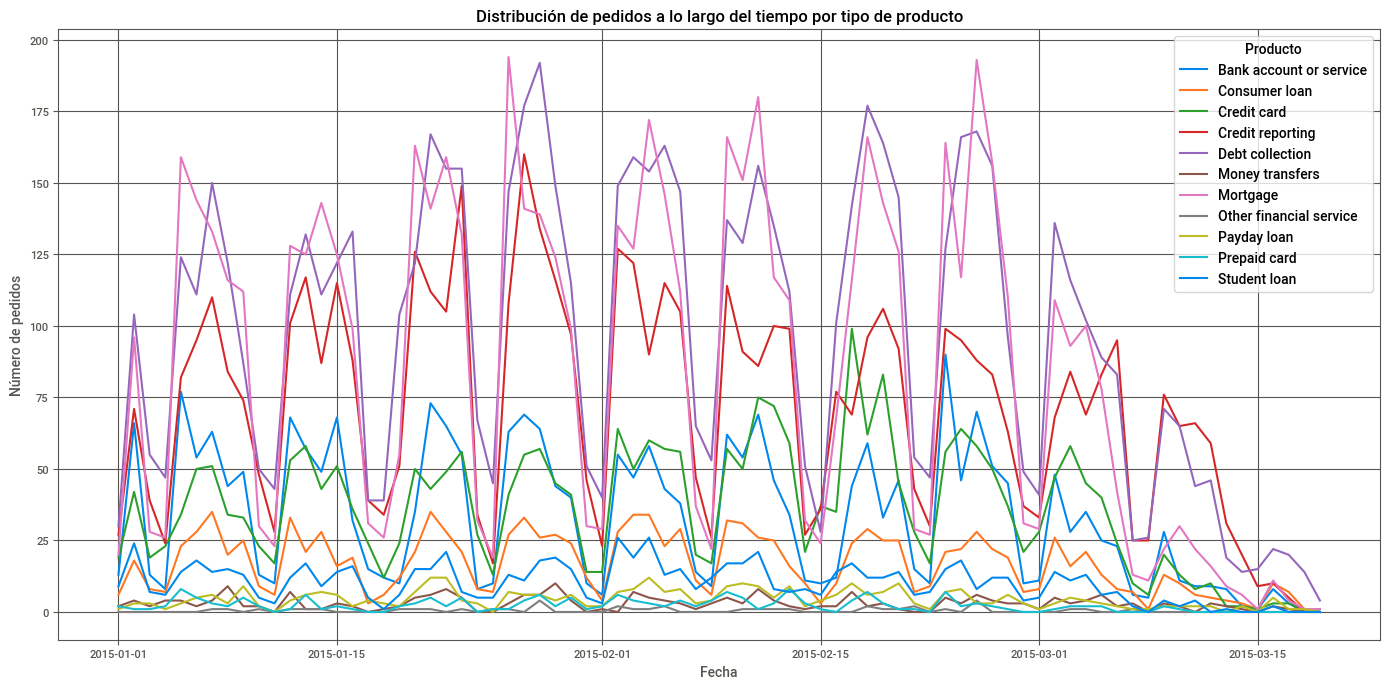

In [305]:
import matplotlib.pyplot as plt

# Asegúrate que la columna de fecha esté en formato datetime
df['Date received'] = pd.to_datetime(df['Date received'], errors='coerce')

# Agrupar por fecha y producto, contando la cantidad de pedidos
pedidos_por_fecha_producto = df.groupby(['Date received', 'Product']).size().unstack(fill_value=0)

# Graficar
plt.figure(figsize=(14, 7))
for producto in pedidos_por_fecha_producto.columns:
    plt.plot(pedidos_por_fecha_producto.index, pedidos_por_fecha_producto[producto], label=producto)

plt.title('Distribución de pedidos a lo largo del tiempo por tipo de producto')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.legend(title='Producto')
plt.grid(True)
plt.tight_layout()
plt.show()


He querido revisar si a nivel de producto todos siguen la misma estacionalidad de los fines de semana o por lo contrario existe algun producto concreto que los fines de semana aumentan las quejas. Efectivamente, en mayor o menor medida todos siguen esta tendencia. Por lo que la fecha n o creo que sea un factor clave para la clasificación correcta de los productos. Por otro lado la ultima tendencia que tienede a reducirse a partir de marzo no le acabo de encontrar el sentido del todo por falta de contexto. En cualquier caso se entiende que apartir de marzo la necesidad de pedirle al banco (he presupuesto por los tipos de productos y subproductos) cosas se disminuye ya sea por finalizaciones de presentaciones de información para declarar balances de la empresa u otros motivos. 

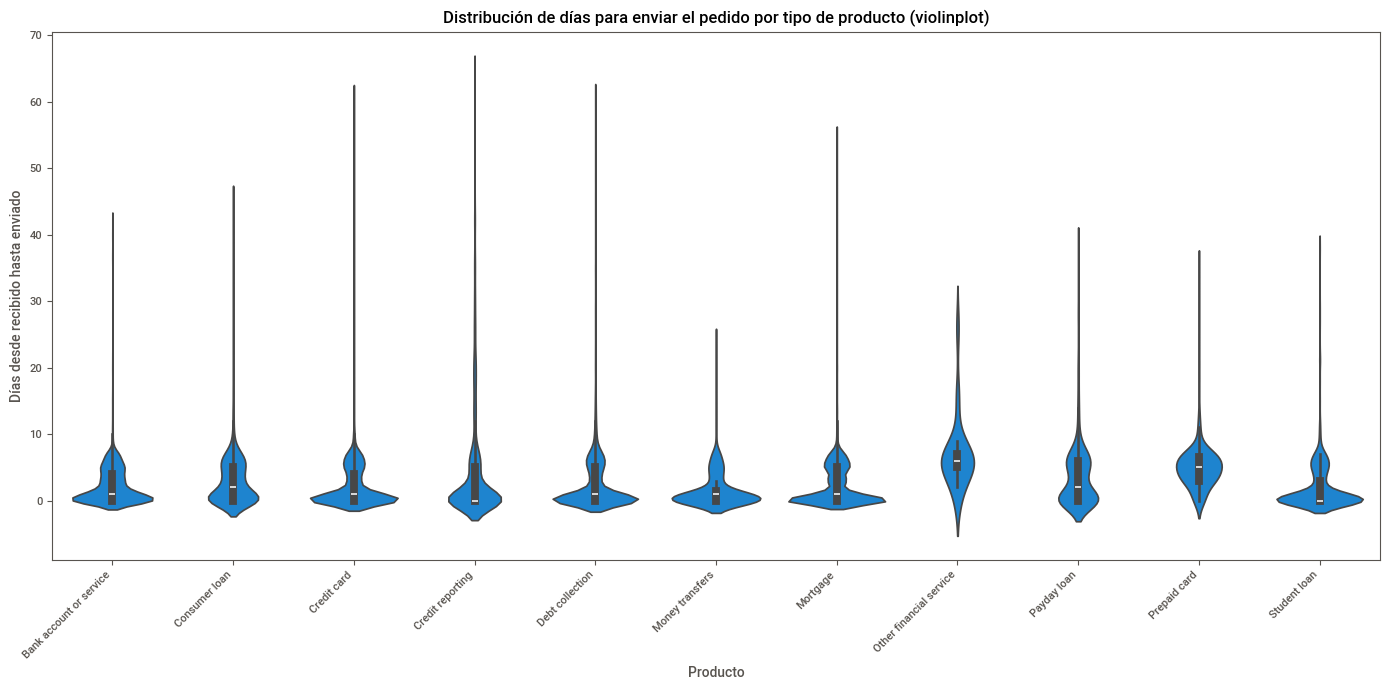

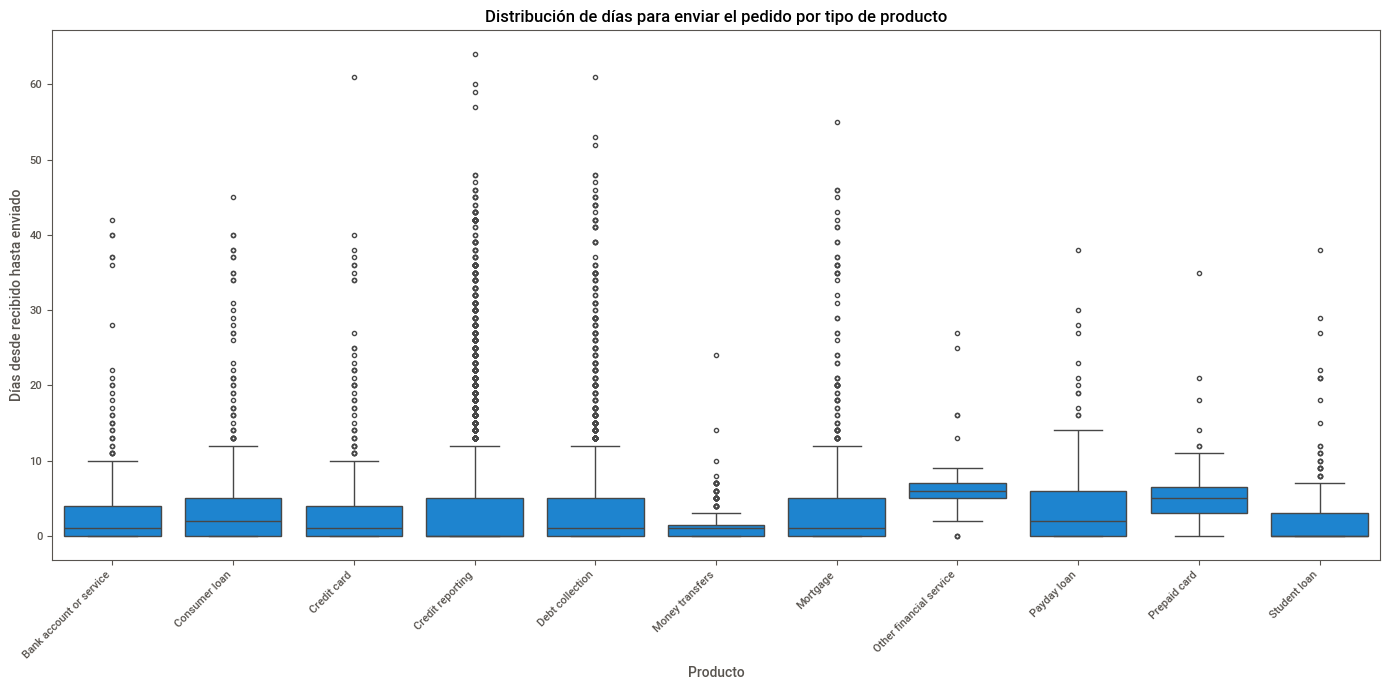

In [306]:
import seaborn as sns

# Calculamos diferencia en días entre recepción y envío para medir tiempos de gestión
df['days_to_send'] = (df['Date sent to company'] - df['Date received']).dt.days

# Visualización de la distribución de tiempos por producto con violinplot (densidad y rango)
plt.figure(figsize=(14, 7))
sns.violinplot(data=df, x='Product', y='days_to_send')
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de días para enviar el pedido por tipo de producto (violinplot)')
plt.ylabel('Días desde recibido hasta enviado')
plt.xlabel('Producto')
plt.tight_layout()
plt.show()

# Complemento con boxplot para mediana, cuartiles y outliers
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='Product', y='days_to_send')
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de días para enviar el pedido por tipo de producto')
plt.ylabel('Días desde recibido hasta enviado')
plt.xlabel('Producto')
plt.tight_layout()
plt.show()


En cuanto a la distribución de los productos en base a los dias desde que se ha recibido hasta que se ha enviado tampoco se destaca ninguna diferenciación circustancial entre los productos. Basicamente todos son enviados en un plazo inferior a 10 dias,por lo que parece que el tratamiento de las quejas es indiferente en cuanto al tiempo en base a los diferentes productos, es decir cualquier producto se resuelve con el mismo margen de tiempo.

Si que podríamos destacar 3 grupos dentro de estos productos. Los rojos que tienen a resolverse en menos tiempo, luego irian los amarillos y por ultimo los verdes que serían los que mas tardan en resolverse.

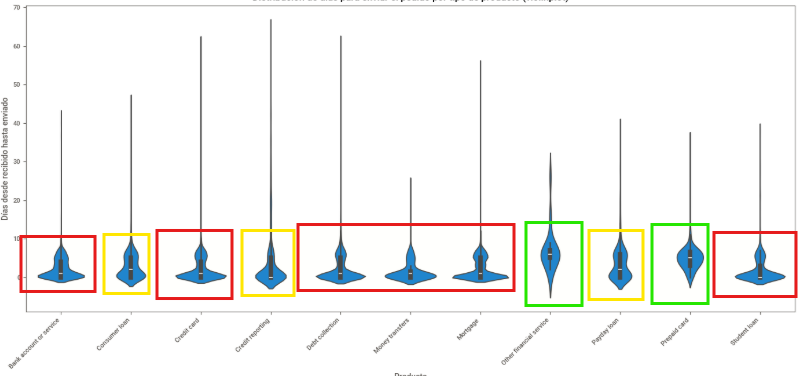

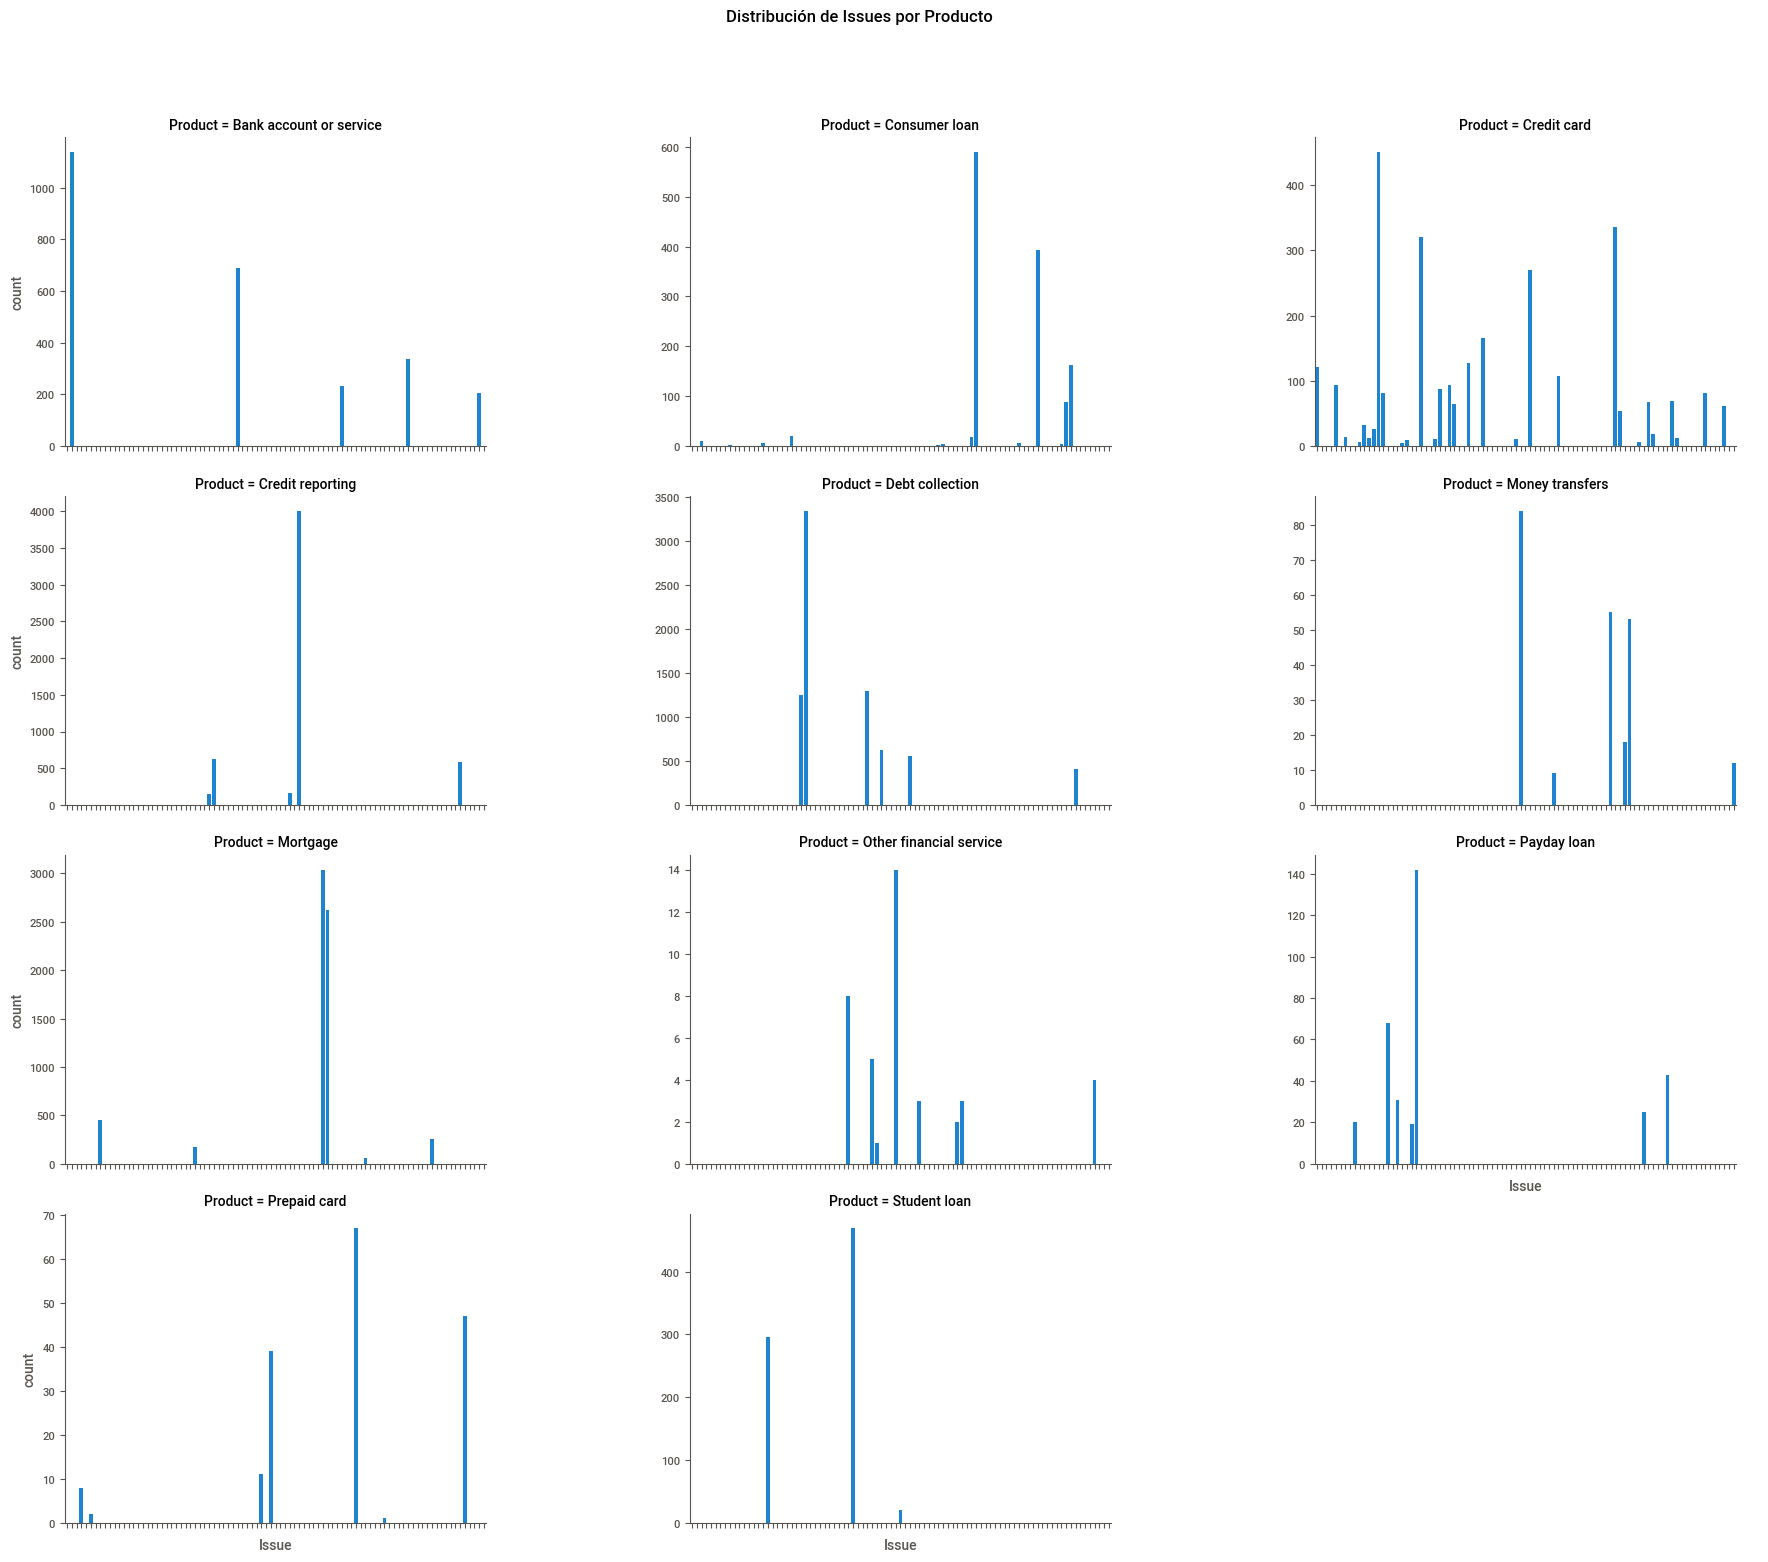

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráficas separadas para la distribución de fallas (Issue) por cada tipo de producto, para comparación directa y clara
g = sns.catplot(data=df, x='Issue', col='Product',
                kind='count', col_wrap=3, height=4, aspect=1.5,
                sharey=False)  # Eje Y independiente por faceta para mejor visualización

g.set_xticklabels(rotation=90)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Distribución de Issues por Producto')
plt.show()


Efectivamente quitando los problemas de tarjeta de credito que es el tipo de problema que más variedad de productos tiene, el resto de problemas suele concentrarse en menos de 6 productos. 

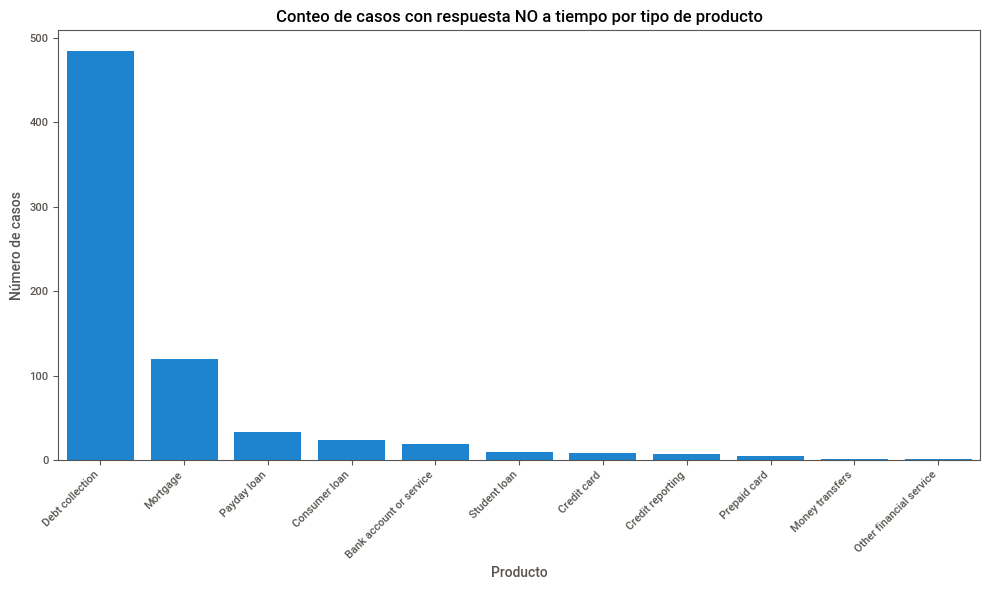

In [308]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar casos en que la empresa NO respondió a tiempo, para identificar productos problemáticos
df_no_timely = df[df['Timely response?'] == 'No']

# Conteo por producto de estos casos y gráfica ordenada para identificar los más problemáticos
plt.figure(figsize=(10, 6))
sns.countplot(data=df_no_timely, x='Product', order=df_no_timely['Product'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Conteo de casos con respuesta NO a tiempo por tipo de producto')
plt.ylabel('Número de casos')
plt.xlabel('Producto')
plt.tight_layout()
plt.show()


Vemos que el producto debt collection es el que mayor cantidad de No obtiene seguido de mortage. Esto indica una clara tendencia de estos productos en caso de recibir un No como respuesta. 

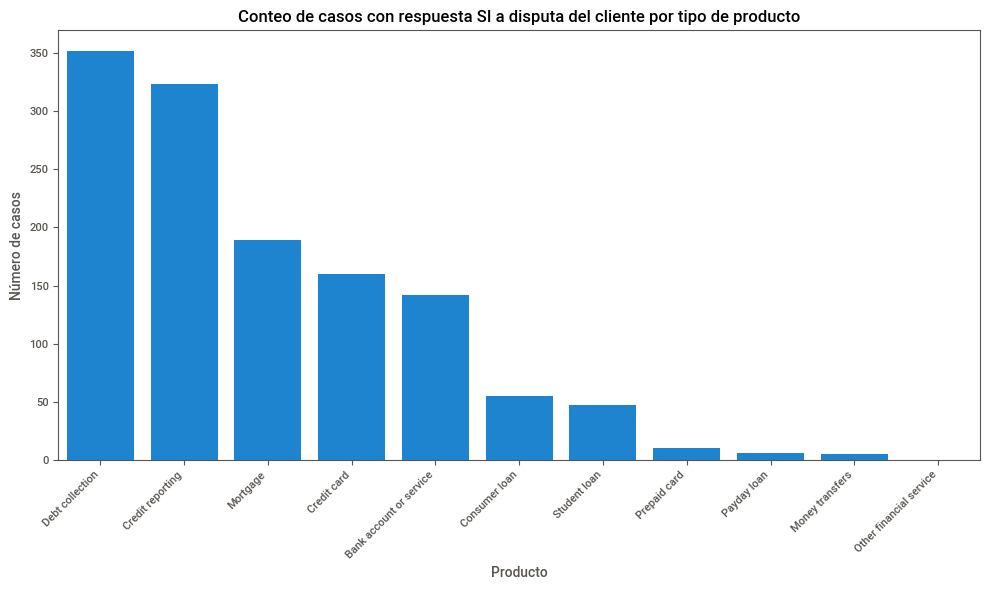

In [309]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar filas donde 'Timely response?' sea 'No'
df_no_timely = df[df['Consumer disputed?'] == 'No'] #Con yes es tambien el top asique será el que menos nulos tiene

# Contar y graficar número de casos por producto
plt.figure(figsize=(10, 6))
sns.countplot(data=df_no_timely, x='Product', order=df_no_timely['Product'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Conteo de casos con respuesta SI a disputa del cliente por tipo de producto')
plt.ylabel('Número de casos')
plt.xlabel('Producto')
plt.tight_layout()
plt.show()

In [1]:
print("Distribución de clases en df['Product'] antes de asignar y:")
print(df['Product'].value_counts())
X = df.drop(columns=['Product'])
y = df['Product']
print("Distribución de clases en y:")
print(y.value_counts())

Distribución de clases en df['Product'] antes de asignar y:


NameError: name 'df' is not defined

Conteos por clase:
Product
Debt collection            7478
Mortgage                   6596
Credit reporting           5527
Credit card                2822
Bank account or service    2605
Consumer loan              1312
Student loan                785
Payday loan                 348
Money transfers             231
Prepaid card                175
Other financial service      40
Name: count, dtype: int64

Porcentaje por clase:
Product
Debt collection            26.784627
Mortgage                   23.625488
Credit reporting           19.796554
Credit card                10.107812
Bank account or service     9.330563
Consumer loan               4.699309
Student loan                2.811705
Payday loan                 1.246463
Money transfers             0.827394
Prepaid card                0.626813
Other financial service     0.143272
Name: count, dtype: float64


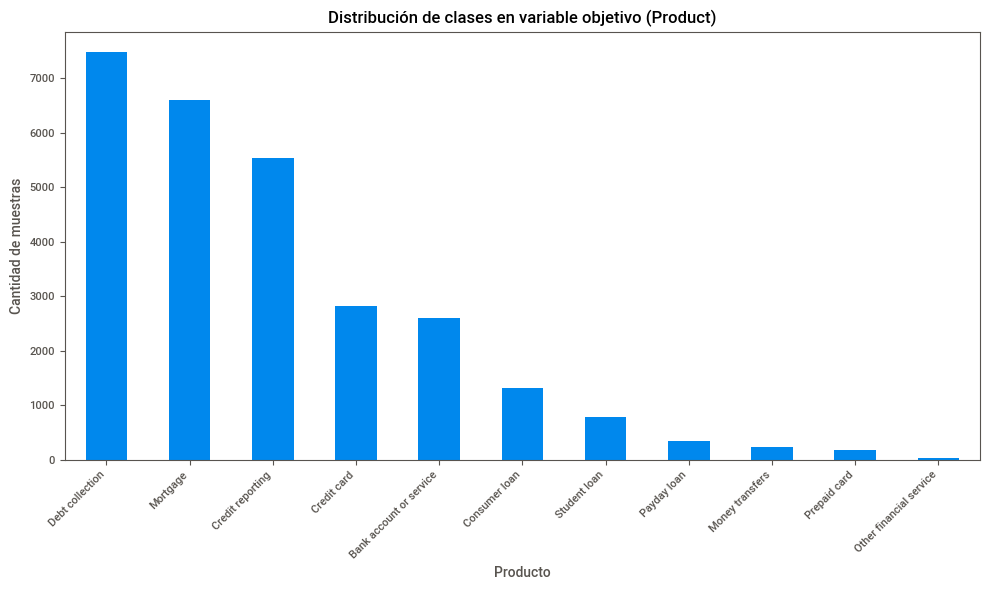

In [311]:
import matplotlib.pyplot as plt

# Revisar distribución de clases para evaluar posible desequilibrio
target_counts = y.value_counts()
print("Conteos por clase:")
print(target_counts)
print("\nPorcentaje por clase:")
print(target_counts / target_counts.sum() * 100)

# Visualización con gráfico de barras para entender balance
plt.figure(figsize=(10, 6))
target_counts.plot(kind='bar')
plt.title('Distribución de clases en variable objetivo (Product)')
plt.xlabel('Producto')
plt.ylabel('Cantidad de muestras')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


El target esta muy desbalanceado como ya hemos visto antes, casi el 90% de los casos pertenece a los 9 primeros productos dejando el 10% restante a otros 6 productos. Tres de estos productos no llegan a una representación ni del 1% por lo que la clase esta bastante descompensada. De momento vamos a seguir a delante sin usar ningun metodo para la compensacion de clases y generacion de muestras sinteticas para mantener el dataset actual que seguramente este representando la realidad. En caso de tener malos resultados se probará con muestras sinteticas. 

In [312]:
# Porcentaje de valores faltantes para cada columna en X
pct_missing = X.isna().mean().mul(100).sort_values(ascending=False)

# Umbral para considerar columna con muchos nulos. Aquí 35% es criterio arbitrario
umbral_missing = 35.0
cols_muchos_missing = pct_missing[pct_missing >= umbral_missing]

print("Porcentaje de nulos (%) por columna:")
print(pct_missing)

print("\nColumnas con muchos missing (>= umbral):")
print(cols_muchos_missing)


Porcentaje de nulos (%) por columna:
Consumer disputed?      78.570149
Sub-issue               53.418819
Sub-product             37.153910
State                    1.500770
ZIP code                 0.995738
Issue                    0.007164
Date sent to company     0.000000
Date received            0.000000
Company                  0.000000
Company response         0.000000
Timely response?         0.000000
days_to_send             0.000000
dtype: float64

Columnas con muchos missing (>= umbral):
Consumer disputed?    78.570149
Sub-issue             53.418819
Sub-product           37.153910
dtype: float64


Con las features más de lo mismo, ya hemos visto antes que problematicas tienen cada una de ellas

In [313]:
# Calcular variable única que resume tiempo entre recepción y envío ####ya lo tenemos calculado
# X['days_diff'] = (X['Date sent to company'] - X['Date received']).dt.days

# Eliminar columnas originales que ya se condensaron para evitar redundancia
X = X.drop(columns=['Date received', 'Date sent to company', 'ZIP code'])


De momento con las features y los valores nulos no se van a tratar. El unico tratamiento va a ser las fechas de envio y recivo que va a pasar a ser una unica columna con la resta. Como features iniciales se van a usar todas, en caso de tener demasiada información las primeras features a eliminar seán las que hemos visto que tienen una gran cantidad de nulos. 

Zip code se ha eliminado y vamos a usar solo el estado como indicador de localidad. 

Posteriormente vamos a valorar si eliminar sub-product puesto que si estamos intentando predecir en un caso real el producto es extraño que no tengamos el producto pero si el subproducto. 

In [314]:
X

,Sub-product,Issue,Sub-issue,State,Company,Company response,Timely response?,Consumer disputed?,days_to_send
0,NaN,Communication tactics,Frequent or repeated calls,TX,"Premium Asset Services, LLC",In progress,Yes,NaN,0
1,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,NaN,0
2,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,RBS Citizens,Closed with explanation,Yes,Yes,0
3,NaN,Other,NaN,CA,Navy FCU,In progress,Yes,NaN,0
4,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,NaN,Transworld Systems Inc.,In progress,Yes,NaN,0
...,...,...,...,...,...,...,...,...,...
28151,NaN,Cont'd attempts collect debt not owed,Debt is not mine,TX,"Enhanced Recovery Company, LLC",Closed with non-monetary relief,Yes,No,1
28152,Vehicle loan,Taking out the loan or lease,NaN,GA,DriveTime,Closed with explanation,Yes,NaN,6
28153,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,MN,Regions,Closed with non-monetary relief,Yes,No,1
28154,NaN,Can't stop charges to bank account,NaN,CA,Moneytree Inc,Closed with explanation,Yes,NaN,6


In [315]:
#   <dt><a href="#errors">12. Anomalías y errores</a></dt>
#       <dd>Detección de datos incoherentes</dd>
    
#   <dt><a href="#outliers">13. Outliers</a></dt>
#       <dd>Tratamos los outliers</dd>